# Machine Learning with Python

## Setup

In [240]:
# Package imports
import matplotlib.pyplot as plt  # data visualisation
import numpy as np  # mathematics
import pandas as pd  # data manipulation
from sklearn.linear_model import LinearRegression  # regression

In [224]:
# Graphical properties
plt.rcParams['figure.facecolor'] = 'white'

In [225]:
# Parameters
BASE_URL = 'https://raw.githubusercontent.com/warwickdatascience/' + \
           'helping-hack-heart-of-england/main/resources/'

## Exploratory Analysis

Data available from the [hackathon website](https://warwickdatascience.github.io/helping-hack-heart-of-england/).

In [226]:
# Data import
imd = pd.read_csv(BASE_URL + 'imd.csv')
ref = pd.read_csv(BASE_URL + 'ref.csv')

In [227]:
# Sample datsets
display(imd.sample(10))
display(ref.sample(10))

,lad_code,lad_name,imd_2015,imd_2019
300,E09000023,Lewisham,0.305029,0.328240
86,E07000062,Hastings,0.292619,NaN
310,E09000033,Westminster,0.353672,NaN
174,E07000155,South Northamptonshire,0.817546,0.830599
74,E07000037,High Peak,0.588292,NaN
25,E06000026,Plymouth,0.405052,0.400079
292,E09000015,Harrow,0.624809,0.608227
201,E07000195,Newcastle-under-Lyme,0.531104,0.519583
210,E07000208,Epsom and Ewell,0.816508,0.813648
262,E08000022,North Tyneside,0.505080,0.491942


,lad_code,lad_name,year,class,expense,category,expenditure
23726,E10000029,Suffolk,2016,SC,Public health advice to NHS commissioners (pre...,Public Health,1010.0
41402,E07000167,Ryedale,2016,SD,Regulatory services: Pest control,Environmental and Regulatory Services,39.0
63070,E06000046,Isle of Wight UA,2017,UA,"Environmental, safety and routine maintenance",Highways and Transport,3032.0
231980,E23000017,Warwickshire Police and Crime Commissioner and...,2019,O,Coroners' court services,Central Services,0.0
235459,E23000031,Surrey Police and Crime Commissioner and Chief...,2019,O,Non-distributed costs - retirement benefits,Central Services,0.0
46448,E31000041,Merseyside Fire and Rescue Authority,2016,O,Agriculture and fisheries services,Environmental and Regulatory Services,0.0
66919,E23000032,Kent Police and Crime Commissioner and Chief C...,2017,O,Public transport: statutory concessionary fares,Highways and Transport,0.0
217505,E08000029,Solihull,2019,MD,Regulatory services: Housing standards,Environmental and Regulatory Services,0.0
32731,E47000002,"The Barnsley, Doncaster, Rotherham and Sheffie...",2016,O,Housing benefits: rent allowances and rent reb...,Housing Services,0.0
183681,E23000037,Gloucestershire Police and Crime Commissioner ...,2019,O,Traffic management and road safety: congestion...,Highways and Transport,0.0


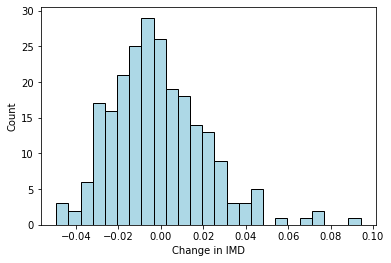

In [228]:
# Change in IMD
imd_train = imd.loc[imd['imd_2019'].notnull()].copy()
imd_train['imd_change'] = imd_train['imd_2019'] - imd_train['imd_2015']

fig, ax = plt.subplots()
ax.hist(imd_train['imd_change'], bins=25,
        edgecolor='black', color='lightblue')
ax.set_xlabel("Change in IMD")
ax.set_ylabel("Count")
plt.show()

In [229]:
# Data aggregation
group_cols = ['lad_code', 'lad_name', 'class', 'category']
ref_agg = ref.groupby(group_cols)['expenditure'].mean().reset_index()
display(ref_agg.sample(10))

,lad_code,lad_name,class,category,expenditure
1210,E07000052,West Dorset,SD,Central Services,373.818182
3299,E07000237,Worcester,SD,Planning and Development Services,212.156250
5556,E31000030,Nottinghamshire Combined Fire and Rescue Autho...,O,Environmental and Regulatory Services,0.000000
1531,E07000083,Tewkesbury,SD,Planning and Development Services,129.781250
2824,E07000197,Stafford,SD,Cultural and Related Services,624.041667
1690,E07000096,Dacorum,SD,Adult Social Care,0.000000
3615,E08000016,Barnsley,MD,Central Services,785.704545
5798,E47000011,North of Tyne Combined Authority,O,Adult Social Care,0.000000
2164,E07000135,Oadby & Wigston,SD,Fire,0.000000
3219,E07000227,Horsham,SD,Housing Services,81.035714


A massive flaw is already obvious: by not including county/London boroughs/other authorities, we are not accurately reflecting spending. We will not address this issue here as this is one way you can approve your leaderboard score.

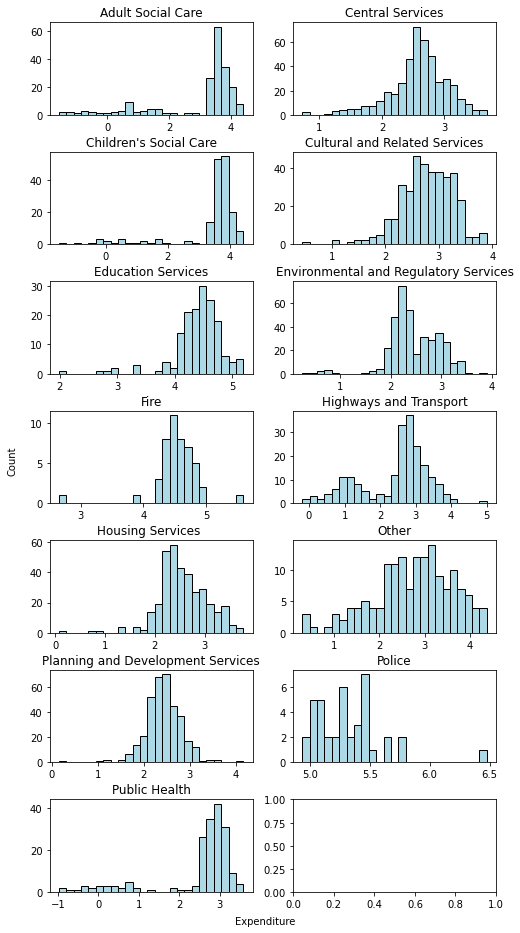

In [230]:
# Expenditure by category
categories = ref_agg['category'].unique()

fig, axs = plt.subplots((len(categories) + 1) // 2, 2,
                        figsize=(8, 16))

for i, cat in enumerate(categories):
    ax = axs[i // 2][i % 2]
    
    ref_sub = ref_agg.loc[(ref_agg['category'] == cat) &
                          (ref_agg['expenditure'] > 0)]
    
    ax.hist(np.log10(ref_sub['expenditure']), bins=25,
            edgecolor='black', color='lightblue')
    ax.set_title(cat)
    
fig.text(0.5, 0.1, 'Expenditure', ha='center', va='center')
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical')
    
plt.subplots_adjust(hspace=0.4)
plt.show()

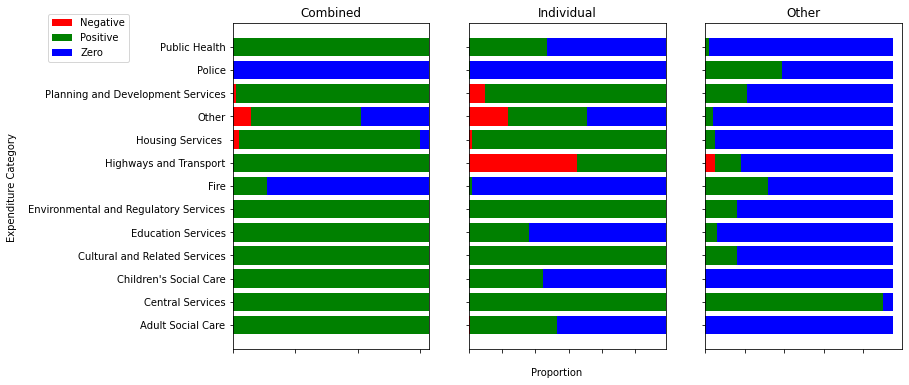

In [231]:
# Expenditure by category and class
ref_agg['expenditure_sign'] = 'Negative'
ref_agg.loc[ref_agg['expenditure'] > 0, 'expenditure_sign'] = 'Positive'
ref_agg.loc[np.isclose(ref_agg['expenditure'], 0), 'expenditure_sign'] = 'Zero'

ref_agg['class_type'] = ref_agg['class'].map({
    'L': 'Individual', 'UA': 'Individual', 'SD': 'Individual',
    'MD': 'Combined', 'SC': 'Combined',
    'O': 'Other'
})

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

for i, ct in enumerate(('Combined', 'Individual', 'Other')):
    ax = axs[i]
    
    ref_sub = ref_agg.loc[ref_agg['class_type'] == ct]
    
    prev_height = 0
    for es, c in zip(('Negative', 'Positive', 'Zero'), ('r', 'g', 'b')):
        ref_sub2 = ref_sub.loc[ref_sub['expenditure_sign'] == es]
        curr_height = ref_sub2.groupby('category')['expenditure'].count()
        curr_height = curr_height.reindex(categories).fillna(0)
        ax.barh(categories, curr_height, left=prev_height, color=c,
                label=es if i == 0 else None)
        ax.set_title(ct)
        prev_height = curr_height + prev_height
        
    if i: ax.set_yticklabels([])
    ax.set_xticklabels([])
    
fig.text(0.5, 0.07, 'Proportion', ha='center', va='center')
fig.text(-0.13, 0.5, 'Expenditure Category',
         ha='center', va='center', rotation='vertical')

fig.legend(loc='upper left', bbox_to_anchor=(0.05, 0, 1, 0.87))
plt.subplots_adjust(hspace=0.4)
plt.show()

/home/tim/miniconda3/envs/general/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


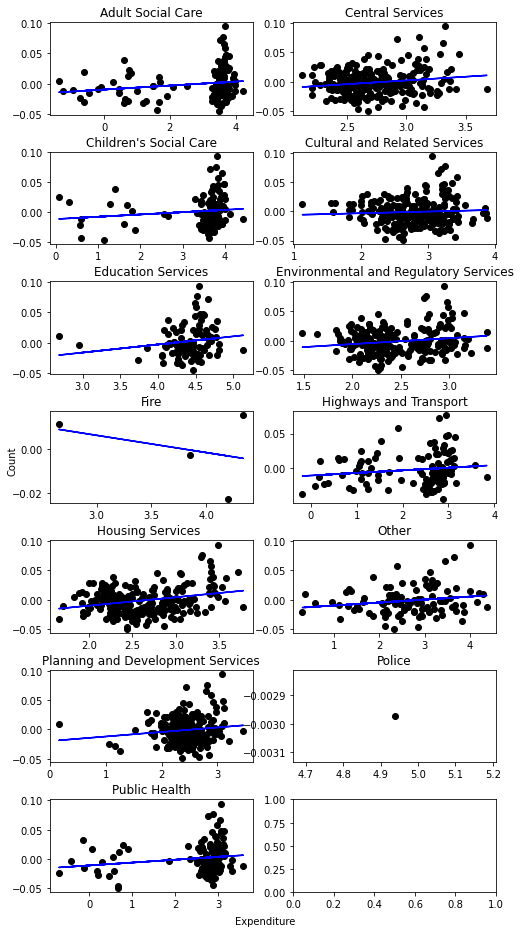

In [234]:
# Correlations
combi_sub = pd.merge(
    imd_train[['lad_code', 'imd_change']],
    ref_agg[['lad_code', 'category', 'expenditure']].loc[
        ref_agg['expenditure'] > 0
    ], how='inner'
)

fig, axs = plt.subplots((len(categories) + 1) // 2, 2,
                        figsize=(8, 16))

for i, cat in enumerate(categories):
    ax = axs[i // 2][i % 2]
    
    combi_sub2 = combi_sub.loc[(combi_sub['category'] == cat)]
    
    exp = np.log10(combi_sub2['expenditure'])
    imd_chng = combi_sub2['imd_change']
    ax.plot(exp, imd_chng, 'ko', exp,
            np.poly1d(np.polyfit(exp, imd_chng, 1))(exp), 'b')
    ax.set_title(cat)
    
fig.text(0.5, 0.1, 'Expenditure', ha='center', va='center')
fig.text(0.06, 0.5, 'Count', ha='center', va='center', rotation='vertical')
    
plt.subplots_adjust(hspace=0.4)
plt.show()

## Modelling

In [235]:
# Transform data
ref_agg['clean_cat'] = ref_agg['category'].str.replace(' ', '_')
ref_agg['clean_cat'] = ref_agg['clean_cat'].str.replace(r'[^\w]+', '')

ref_wide = ref_agg.pivot_table(index=['lad_code', 'lad_name', 'class'],
                               columns='clean_cat',
                               values='expenditure').reset_index()
ref_wide.columns.name = None
display(ref_wide.sample(10))

,lad_code,lad_name,class,Adult_Social_Care,Central_Services,Childrens_Social_Care,Cultural_and_Related_Services,Education_Services,Environmental_and_Regulatory_Services,Fire,Highways_and_Transport,Housing_Services_,Other,Planning_and_Development_Services,Police,Public_Health
161,E07000130,Charnwood,SD,0.000000,434.522727,18.87500,482.208333,0.000000,238.580357,0.0,24.483333,357.035714,-470.25,221.18750,0.00,0.000000
220,E07000200,Babergh,SD,0.000000,166.454545,0.00000,248.916667,0.000000,95.750000,0.0,12.233333,258.535714,0.00,354.37500,0.00,0.000000
272,E08000010,Wigan,MD,4579.861111,1058.772727,4658.40625,1552.708333,38737.083333,764.357143,0.0,456.150000,718.678571,6962.75,318.46875,0.00,1080.052083
120,E07000086,Eastleigh,SD,0.000000,871.931818,0.00000,221.291667,0.000000,140.187500,0.0,-52.966667,106.250000,0.00,223.46875,0.00,0.000000
388,E23000030,Hampshire Police and Crime Commissioner and Ch...,O,0.000000,149.500000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00000,308908.75,0.000000
389,E23000031,Surrey Police and Crime Commissioner and Chief...,O,0.000000,208.954545,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00000,218992.25,0.000000
323,E09000025,Newham,L,4324.819444,906.090909,7467.87500,1978.791667,60053.750000,971.491071,0.0,392.166667,2497.785714,1044.50,1303.87500,0.00,1326.770833
372,E23000014,West Midlands Police and Crime Commissioner an...,O,0.000000,197.227273,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00000,588860.35,0.000000
436,E31000047,Dorset and Wiltshire Fire and Rescue Authority,O,0.000000,128.909091,0.00000,0.000000,0.000000,0.000000,54756.0,0.000000,0.000000,0.00,0.00000,0.00,0.000000
39,E06000040,Windsor & Maidenhead UA,UA,2146.486111,485.295455,1991.03125,471.125000,12131.291667,511.383929,0.0,27.866667,563.821429,0.00,269.84375,0.00,205.750000


In [252]:
# Combine datasets
combi_train = pd.merge(
    imd_train[['lad_code', 'imd_change']],
    ref_wide.drop(['lad_name', 'class'], axis=1),
    how='left'
)

In [250]:
# Build model
reg = LinearRegression()
reg.fit(combi_train.drop(['lad_code', 'imd_change'], axis=1),
        combi_train['imd_change']);  # baseline model on leaderboard

_For null model checks and ANOVA, see the R version of this notebook._

## Output

In [266]:
# Make predictions
imd_test = imd.loc[imd['imd_2019'].isnull()].copy()[['lad_code', 'imd_2015']]
combi_test = pd.merge(
    imd_test, ref_wide.drop(['lad_name', 'class'], axis=1),
    how='left'
)
pred = reg.predict(combi_test.drop(['lad_code', 'imd_2015'], axis=1))

In [270]:
# Output predictions
imd_test['imd_2019'] = imd_test['imd_2015'] + pred
imd_test.to_csv('tutorial.csv')

## Closing Notes

### Comments

Possible improvements:
- Use lookup tables to bring in all data sources
- Consider using multi-level modeling techniques
- Implement cross-validation to ensure generalisation
- Use regularisation to reduce generalisation gap
- Consider more complex models
- Model using a transformed expenditure
- Use time series modelling

### Learning Resources

- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)
- [Python Cookbook](https://d.cxcore.net/Python/Python_Cookbook_3rd_Edition.pdf)
- [DataCamp Trial](https://www.datacamp.com/github-students)
